In [29]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from scipy import sparse
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib_venn as venn


In [23]:
train = pd.read_csv('data/train.csv')
test =  pd.read_csv('data/test.csv')
test_label = pd.read_csv('data/test_labels.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
print(train.shape)
print(test.shape)

(159571, 8)
(153164, 2)


In [10]:
sum(train['toxic']==0)/train.shape[0]*100

90.41555169799024

In [5]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
test_label.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


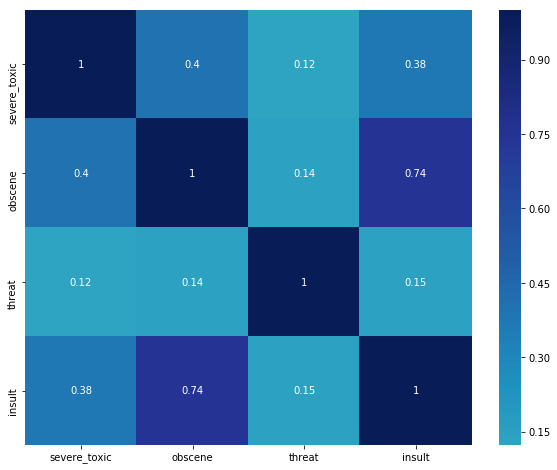

In [12]:
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]
temp_df=train.iloc[:,3:-1]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True,center=0,cmap='YlGnBu',)

In [40]:
text

array(['COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK',
       'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...',
       "Bye! \n\nDon't look, come or think of comming back! Tosser.", ...,
       "Your absurd edits \n\nYour absurd edits on great white shark was total vandalism and was very sexual. All you edit here is fucking bullshit like spam all over this useful encyclopedia so stop all your bullshit. The admins have you everywhere. The only choice for you is to stop this bullshit or else you'll be blocked permanently. User:Factual80man",
       '"\n\nHey listen don\'t you ever!!!! Delete my edits ever again I\'m annoyed because the WWE 2K15 a few of the roster have been confirmed and your stupid ass deletes what

In [40]:
import nltk
from nltk.corpus import stopwords
eng_stop = set(stopwords.words("english"))


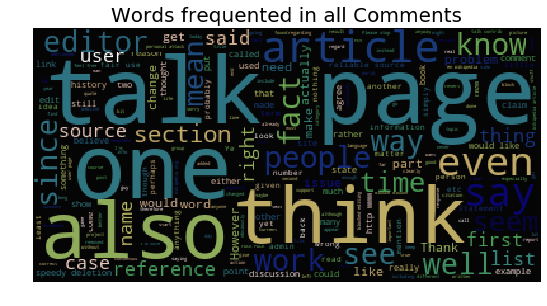

In [36]:
text=train.iloc[:,1]
wc= WordCloud(background_color="black",max_words=10000,stopwords=eng_stop)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in all Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth'), alpha=0.98)

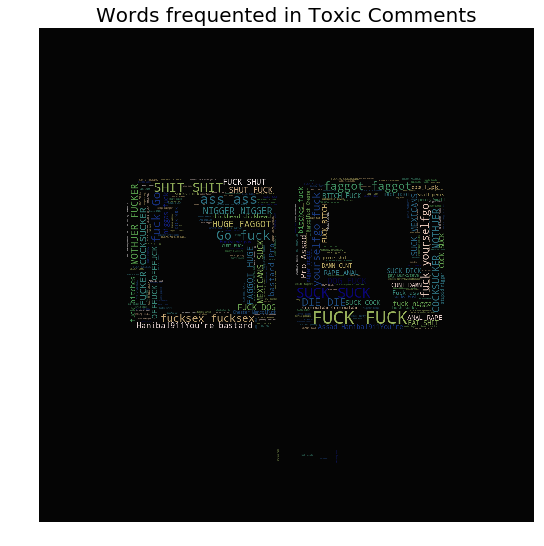

In [72]:
toxic_mask=np.array(Image.open("hh.jpg"))
toxic_mask=toxic_mask[:,:,0:2]
subset=train[train.severe_toxic==1 ]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=10000,mask=toxic_mask,stopwords=eng_stop)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth'), alpha=0.98)

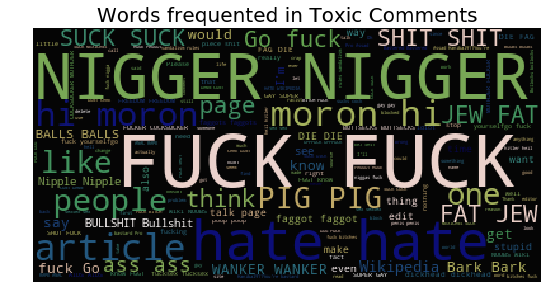

In [34]:
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=10000,stopwords=eng_stop)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth'), alpha=0.98)

# Indirect features:
Some more experimental features.

count of sentences
count of words
count of unique words
count of letters
count of punctuations
count of uppercase words/letters
count of stop words
Avg length of each word


In [37]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [47]:
from nltk.corpus import stopwords
set(stopwords.words('english'))
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
#df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
df = df.dropna()

In [128]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
#df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [143]:
#serperate train and test features
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

In [144]:
train_feats

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,2,11,20,5.162791,95.348837,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,1,3,3,5.588235,100.000000,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,0,2,21,4.571429,92.857143,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,5,7,58,4.486726,72.566372,0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,0,2,6,4.230769,100.000000,0,0,0,0,0,0,True
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",3,13,12,65,0,1,4,3.923077,92.307692,0,0,0,0,0,0,True
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,8,8,44,8,0,4,4.625000,100.000000,1,1,1,0,1,0,False
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,1,20,20,115,0,4,11,4.750000,100.000000,0,0,0,0,0,0,True
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,1,83,70,472,1,5,45,4.698795,84.337349,0,0,0,0,0,0,True
9,00040093b2687caa,alignment on this subject and which are contra...,1,12,12,70,0,0,8,4.916667,100.000000,0,0,0,0,0,0,True


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


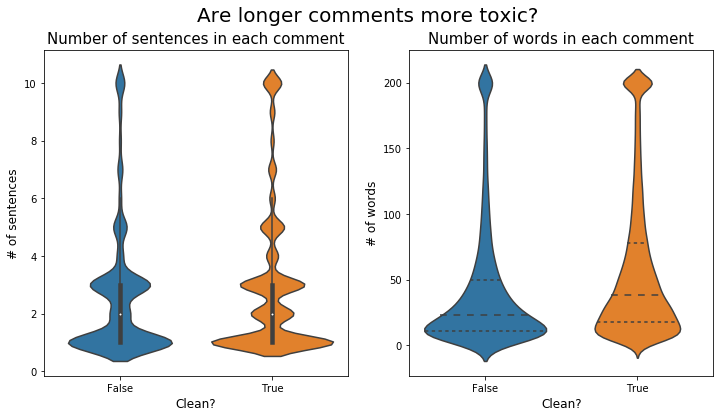

In [145]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

Long sentences or more words do not seem to be a significant indicator of toxicity.



In [90]:
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

In [16]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [18]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [19]:
maxlen = 300
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [20]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]


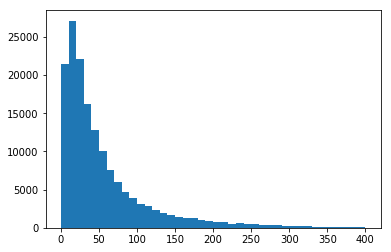

In [21]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [22]:
inp = Input(shape=(maxlen, )) 

In [23]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [24]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)


In [25]:
x = GlobalMaxPool1D()(x)


In [26]:
x = Dropout(0.1)(x)


In [27]:
x = Dense(50, activation="relu")(x)


In [28]:
x = Dropout(0.1)(x)


In [29]:
x = Dense(6, activation="sigmoid")(x)


In [30]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [31]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1537s 11ms/step - loss: 0.0680 - acc: 0.9781 - val_loss: 0.0492 - val_acc: 0.9820
Epoch 2/2
143613/143613 [==============================] - 1554s 11ms/step - loss: 0.0458 - acc: 0.9830 - val_loss: 0.0484 - val_acc: 0.9824


In [32]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 300, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [33]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape

(1, 300, 60)

In [35]:
predict = model.predict(X_te)

In [58]:
X_te

array([[   0,    0,    0, ...,  145,  493,   84],
       [   0,    0,    0, ...,   11,    8, 2826],
       [   0,    0,    0, ...,  109,   15,  355],
       ...,
       [   0,    0,    0, ...,   12, 1652,  358],
       [   0,    0,    0, ..., 9844, 3506,  355],
       [   0,    0,    0, ...,  100, 5220,    6]])

In [63]:
predict1  = pd.DataFrame(predict)
predict1.columns = list_classes


In [114]:
predict1.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,id
id,,,,,,,
00001cee341fdb12,0.993875,0.238835,0.970336,0.086085,0.901972,0.152450,00001cee341fdb12
0000247867823ef7,0.001237,0.000004,0.000131,0.000011,0.000226,0.000041,0000247867823ef7
00013b17ad220c46,0.000854,0.000002,0.000133,0.000007,0.000165,0.000031,00013b17ad220c46
00017563c3f7919a,0.001580,0.000003,0.000089,0.000006,0.000163,0.000030,00017563c3f7919a
00017695ad8997eb,0.005956,0.000027,0.000760,0.000095,0.001357,0.000247,00017695ad8997eb


In [116]:
predict1.index = test_label.iloc[:,0]
predict2= predict1.iloc[:,0:6]

In [117]:
predict2.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.993875,0.238835,0.970336,0.086085,0.901972,0.152450
0000247867823ef7,0.001237,0.000004,0.000131,0.000011,0.000226,0.000041
00013b17ad220c46,0.000854,0.000002,0.000133,0.000007,0.000165,0.000031
00017563c3f7919a,0.001580,0.000003,0.000089,0.000006,0.000163,0.000030
00017695ad8997eb,0.005956,0.000027,0.000760,0.000095,0.001357,0.000247


In [118]:
predict2.to_csv('hhh.csv')
